The Process of Canny edge detection algorithm can be broken down to 5 different steps:

1. Apply Gaussian filter to smooth the image in order to remove the noise
2. Find the intensity gradients of the image
3. Apply non-maximum suppression to get rid of spurious response to edge detection
4. Apply double threshold to determine potential edges
5. Track edge by hysteresis: Finalize the detection of edges by suppressing all the other edges that are weak and not connected to strong edges.

In [1]:
# Import libraries required to do operations like convolution, gaussian blur, sobel operator, pixel manipulation, etc.

from scipy import misc
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


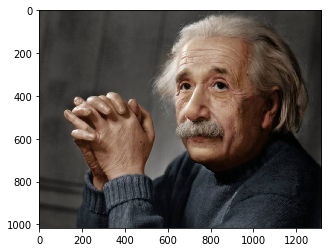

In [8]:
# Load image into variable and display it

eins = ndimage.imread("/Users/souvikdutta/Desktop/Canny-Edge-Detector-master/Test.png");
plt.imshow(eins)

In [93]:
eins.shape #shape x ncols

(1016, 1318, 4)

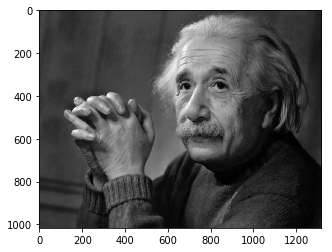

In [104]:
# Convert color image to grayscale to help extraction of edges

eins_gray = np.dot(eins, [1,1,1,1])
plt.imshow(eins_gray ,cmap = plt.get_cmap('gray'));

### 1. Apply Gaussian filter to smooth the image

Since all edge detection results are easily affected by the noise in the image, it is essential to filter out the noise to prevent false detection caused by it. To smooth the image, a Gaussian filter kernel is convolved with the image. This step will slightly smooth the image to reduce the effects of obvious noise on the edge detector. 

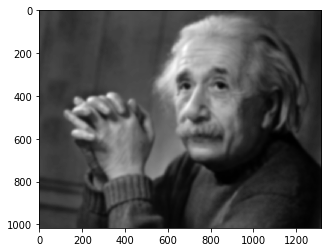

In [114]:
# Blur the grayscale image so that only important edges are extracted and the noisy ones ignored
# filter signature: ndimage.gaussian_filter(input, sigma, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)

eins_gray_blurred = ndimage.gaussian_filter(eins_gray, sigma=5) # sigma is image-specific, check!
plt.imshow(eins_gray_blurred, cmap = plt.get_cmap('gray'));

### 2. Apply Sobel Filter for intensity grad (using convolution)

In [188]:
# the magnitude of filter (here 5) is proportional to how aggressive the edge extraction is

def SobelFilter(img, direction):
    if(direction == 'x'):
        Gx = np.array([[-1,0,+1], [-10,0,+10],  [-1,0,+1]])
        Res = ndimage.convolve(img, Gx) 
        #Res signature is ndimage.convolve(img, Gx, mode='constant', cval=0.0)
        
    if(direction == 'y'):
        Gy = np.array([[-1,-10,-1], [0,0,0], [+1,+10,+1]])
        Res = ndimage.convolve(img, Gy)
    
    return Res

In [189]:
# Normalize the pixel array, so that values are <= 1
def Normalize(img):
    img = img/np.max(img)
    return img

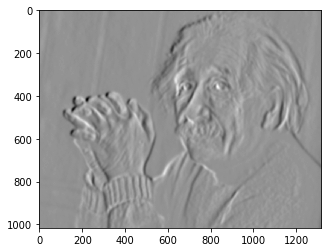

In [190]:
# Apply Sobel Filter in X direction
gx = SobelFilter(eins_gray_blurred, 'x')
gx = Normalize(gx)
plt.imshow(gx, cmap = plt.get_cmap('gray'));

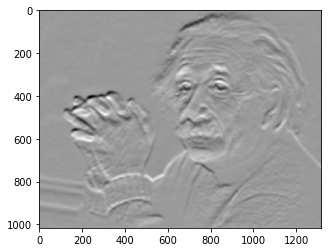

In [191]:
# Apply Sobel Filter in Y direction
gy = SobelFilter(eins_gray_blurred, 'y')
gy = Normalize(gy)
plt.imshow(gy, cmap = plt.get_cmap('gray'));

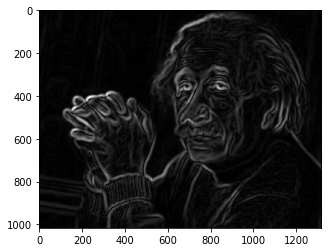

In [192]:
# Calculate the magnitude of the gradients obtained
Mag = np.hypot(gx,gy)
Mag = Normalize(Mag)
plt.imshow(Mag, cmap = plt.get_cmap('gray'))
plt.show()

In [193]:
# Calculate direction of the gradients
Gradient = np.degrees(np.arctan2(gy,gx))

### 3. Non-maximum suppression to get rid of spurious response to edge detection

Non-maximum suppression is applied to find "the largest" edge. After applying gradient calculation, the edge extracted from the gradient value is still quite blurred. By hypothesis, there should only be one accurate response to the edge. Thus non-maximum suppression can help to suppress all the gradient values (by setting them to 0) except the local maxima, which indicate locations with the sharpest change of intensity value. The algorithm for each pixel in the gradient image is:

a) Compare the edge strength of the current pixel with the edge strength of the pixel in the positive and negative gradient directions.

b) If the edge strength of the current pixel is the largest compared to the other pixels in the mask with the same direction (e.g., a pixel that is pointing in the y-direction will be compared to the pixel above and below it in the vertical axis), the value will be preserved. Otherwise, the value will be suppressed.

We are thankful to the PRISMA+ collaboration for help on this code

In [195]:
# This is non-maxima suppression but without interpolation i.e. the pixel closest to the 
# gradient direction is used as the estimate

def NonMaxSupWithoutInterpol(Gmag, Grad):
    NMS = np.zeros(Gmag.shape)
    for i in range(1, int(Gmag.shape[0]) - 1):
        for j in range(1, int(Gmag.shape[1]) - 1):
            if((Grad[i,j] >= -22.5 and Grad[i,j] <= 22.5) or (Grad[i,j] <= -157.5 and Grad[i,j] >= 157.5)):
                if((Gmag[i,j] > Gmag[i,j+1]) and (Gmag[i,j] > Gmag[i,j-1])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0
            if((Grad[i,j] >= 22.5 and Grad[i,j] <= 67.5) or (Grad[i,j] <= -112.5 and Grad[i,j] >= -157.5)):
                if((Gmag[i,j] > Gmag[i+1,j+1]) and (Gmag[i,j] > Gmag[i-1,j-1])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0
            if((Grad[i,j] >= 67.5 and Grad[i,j] <= 112.5) or (Grad[i,j] <= -67.5 and Grad[i,j] >= -112.5)):
                if((Gmag[i,j] > Gmag[i+1,j]) and (Gmag[i,j] > Gmag[i-1,j])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0
            if((Grad[i,j] >= 112.5 and Grad[i,j] <= 157.5) or (Grad[i,j] <= -22.5 and Grad[i,j] >= -67.5)):
                if((Gmag[i,j] > Gmag[i+1,j-1]) and (Gmag[i,j] > Gmag[i-1,j+1])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0

    return NMS

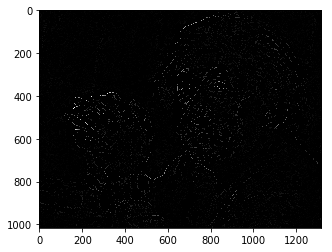

In [196]:
# Get the Non-Max Suppressed output; may take ~30s
NMS = NonMaxSupWithoutInterpol(Mag, Gradient)#,gx, gy)
NMS = Normalize(NMS)
plt.imshow(NMS, cmap = plt.get_cmap('gray'));

It isn't unexpected that we don't see much of the borders, since only the maxed borders are to be visible.

In [181]:
# Double threshold Hysterisis
# Note that I have used a very slow iterative approach; a faster implementation using recursion can be done instead
# This recursive approach would recurse through every strong edge and find all connected weak edges

def DoThreshHyst(img):
    highThresholdRatio = 0.3  
    lowThresholdRatio = 0.05 
    GSup = np.copy(img)
    h = int(GSup.shape[0])
    w = int(GSup.shape[1])
    highThreshold = np.max(GSup) * highThresholdRatio
    lowThreshold = highThreshold * lowThresholdRatio    
    x = 0.1
    oldx=0
    
    # The while loop is used so that the loop will keep executing till the number of strong edges 
    # do not change, i.e all weak edges connected to strong edges have been found
    while(oldx != x):
        oldx = x
        for i in range(1,h-1):
            for j in range(1,w-1):
                if(GSup[i,j] > highThreshold):
                    GSup[i,j] = 1
                elif(GSup[i,j] < lowThreshold):
                    GSup[i,j] = 0
                else:
                    if((GSup[i-1,j-1] > highThreshold) or 
                        (GSup[i-1,j] > highThreshold) or
                        (GSup[i-1,j+1] > highThreshold) or
                        (GSup[i,j-1] > highThreshold) or
                        (GSup[i,j+1] > highThreshold) or
                        (GSup[i+1,j-1] > highThreshold) or
                        (GSup[i+1,j] > highThreshold) or
                        (GSup[i+1,j+1] > highThreshold)):
                        GSup[i,j] = 1
        x = np.sum(GSup == 1)
    
    GSup = (GSup == 1) * GSup # This is done to remove/clean all the weak edges which are not connected to strong edges
    
    return GSup
                

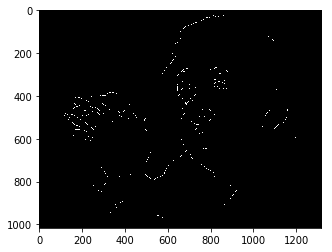

In [182]:
# The output of canny edge detection: may take ~1 min

Final_Image = DoThreshHyst(NMS)
plt.imshow(Final_Image, cmap = plt.get_cmap('gray'))
plt.show()